This notebook contains code to train PCA and hSFA transformers on Miniworld environments.

In [13]:
import gymnasium as gym
import miniworld
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA

# Loading and investigating the environment

In [20]:
# Specify the name of your environment here
env_name = "MiniWorld-WallGapEmpty-v0"
env = gym.make(env_name, view="agent", render_mode="rgb_array", max_episode_steps=100000)
obs, info = env.reset()
print(f"{obs.shape} | {info} | Action space: {env.action_space}")

(60, 80, 3) | {} | Action space: Discrete(3)


In [3]:
obs, rew, term, trunc, info = env.step(env.action_space.sample())

In [4]:
print(f"{obs.shape} | {rew} | {term} | {trunc} | {info}")
print(f"Position of the agent: {env.agent.pos}")
print(f"Viewing angle of the agent: {env.agent.dir%(2*np.pi)}") # Viewing angle is in radians but not normalized

(60, 80, 3) | 0 | False | False | {}
Position of the agent: [-3.97143518  0.          4.61166472]
Viewing angle of the agent: 5.934576266901289


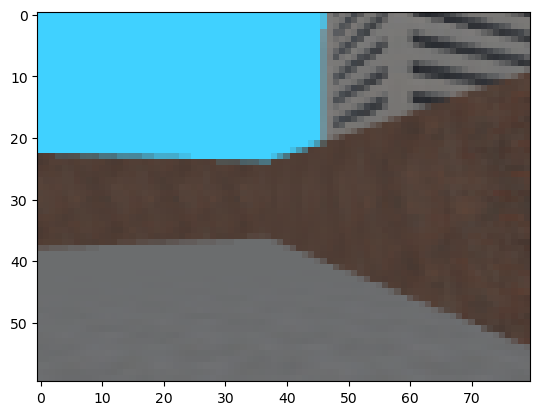

In [5]:
plt.imshow(obs)

In [6]:
def generate_top_view(env = "MiniWorld-StarMazeArm-v0", mode = "bw"):
    """
    Generates top view of the environment.
    Args:
        env (str): The environment
        mode (str): "bw" returns black white view, "bg" a black and grey view,
                "color" returns the original (including an agent placed somewhere)
    Returns:
        Tuple (extents, top_view), where extents is an array [min_x, max_x, min_z, max_z] of the view,
        and top_view is a shape (600, 800) array
    """
    tmp_env = gym.make(env, view="top", render_mode="rgb_array")
    tmp_env.reset()
    top_view = tmp_env.render()
    if mode in ["bw", "bg"]:
        top_view = np.equal(np.mean(top_view, axis=2), 176)
    if mode == "bg":
        top_view = np.where(top_view==1, 1, 0.3)
    # extent = np.array([(tmp_env.min_x - 1)*8/6, (tmp_env.max_x + 1)*8/6, tmp_env.min_z - 1, tmp_env.max_z + 1])
    extent = np.array([tmp_env.render_min_x, tmp_env.render_max_x, tmp_env.render_min_z, tmp_env.render_max_z])
    return extent, np.flip(top_view) # The view should be flipped to work correctly with imshow and the extents

array([-12.,  12.,  -9.,   9.])

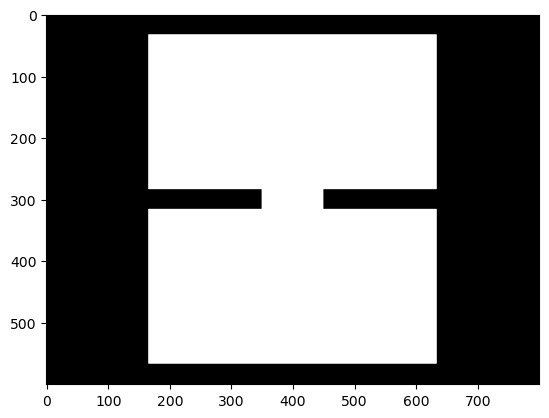

In [7]:
extents, view = generate_top_view(env = env_name, mode="bw")
plt.imshow(view, cmap="Greys", vmin=0)
extents

# Collecting training data

In [8]:
def collect_data(num_steps = 10000, mode="rand", noise=0.7):
    """
    Data should be required on "MiniWorld-StarMaze-v0" since this doesn't have a goal (i.e. box) in it.
    Args:
        num_steps (int): How many observations to gather
        mode (str): Which collection procedure to apply. Valid are "rand" for random, "systematic" for walking along the right wall,
                    "syst_rand" for a mixture of both
    """
    # Actions are 0 (turn left), 1 (turn right), 2 (move forward)
    observations = np.zeros((num_steps, 60, 80, 3))
    positions = np.zeros((num_steps, 3))
    actions = np.zeros((num_steps))
    directions = np.zeros((num_steps))
    i = 0
    pbar = tqdm(total=num_steps)
    while i < num_steps:
        match mode:
            case "rand":
                obs, acts, pos, rot = _rand_action(env)
            case "syst":
                obs, acts, pos, rot = _syst_action(env)
            case "syst_rand":
                obs, acts, pos, rot = _syst_rand_action(env, noise)
        if i+len(obs) > num_steps: # Potentially crop if num_steps is reached
            obs = obs[:num_steps-i]
            acts = acts[:num_steps-i]
            pos = pos[:num_steps-i]
            rot = rot[:num_steps-i]
        observations[i:i+len(obs)] = obs
        actions[i:i+len(acts)] = acts
        positions[i:i+len(pos)] = pos
        directions[i:i+len(rot)] = rot
        i += len(obs)
        pbar.update(len(obs))
    pbar.close()
    return observations, positions, actions, np.round(directions%(2*np.pi), 4) # Sort out multiples of direction beyond 2pi

def _rand_action(env):
    action = env.action_space.sample()
    obs, _, _, _, _ = env.step(action)
    return [obs], [action], [env.agent.pos], [env.agent.dir]

def _syst_action(env):
    # Walk alongside the right wall. This will just walk in circles if it doesn't find a wall!
    obs1, _, _, _, _ = env.step(1) # Turn right
    obs2, _, _, _, _ = env.step(2) # Move forward
    if np.array_equal(obs1, obs2): # If moving forward didn't work
        obs3, _, _, _, _ = env.step(0) # Turn back left
    else:
        return [obs1, obs2], [1,2], [env.agent.pos]*2, [env.agent.dir]*2
    obs4, _, _, _, _ = env.step(2) # Move forward
    if np.array_equal(obs3, obs4): # If moving forward didn't work
        obs5, _, _, _, _ = env.step(0) # Turn left
        return [obs5], [0], [env.agent.pos], [env.agent.dir]
    else:
        return [obs4], [2], [env.agent.pos], [env.agent.dir]

def _syst_rand_action(env, noise):
    if np.random.random() > noise:
        return _syst_action(env)
    else:
        return _rand_action(env)

In [9]:
obs, pos, act, rot = collect_data(num_steps = 100000, mode = "rand")

  0%|          | 0/100000 [00:00<?, ?it/s]

## Visually check collected data

In [10]:
def visualize_positions(positions, view, extents, line=True, colors=None, title=None, ax=None):
    """
    Creates a visualization of the agent's path. If colors==None, colors go from bright red (early positions) to dark red (late positions).
    Args:
        positions (np.ndarray): Array of shape (num_positions, 3) of positions
        view (np.ndarray): Array of shape (600, 800) or (600, 800, 3) that has a top view of the environment
        extents (np.ndarray): Array of shape (4) that specifies [min_x, max_x, min_z, max_z] of the view
        line (bool): Whether to plot a line plot or a scatter plot
        colors (np.ndarray): None, or array of shape (num_positions) which will be scaled to [-1,1] for a diverging color map
        title (str): A title for the plot
        ax (matplotlib.axes._axes.Axes): An axis object to plot into, if available
    """
    axis_was_none = False
    if ax is None:
        axis_was_none = True
        fig, ax = plt.subplots()
    if colors is None:
        colors = np.linspace(0.2, 1, len(positions))
    else:
        colors = np.where(colors >= 0, colors/np.max(colors), -colors/np.min(colors))
    ax.imshow(view, cmap="Greys", extent=extents)
    if line:
        points = np.array([positions[:,0], positions[:,2]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap="seismic", norm=Normalize(vmin=-1, vmax=1)) # norm is required because otherwise the colormap gets rescaled
        lc.set_array(colors)
        ax.add_collection(lc)
    else:
        ax.scatter(positions[:,0], positions[:,2], c=colors, cmap="seismic", norm=Normalize(vmin=-1, vmax=1), s=0.03, alpha=1)
    ax.set_title(title)
    if axis_was_none:
        plt.show()
        plt.close()

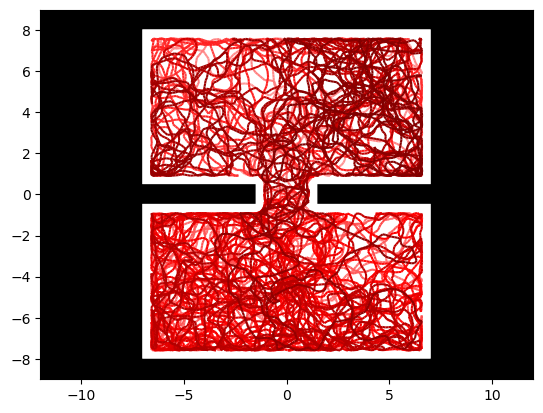

In [11]:
visualize_positions(pos, view, extents)

# Train transformers

## PCA


In [15]:
# Train the PCA transformer
pca = PCA(n_components = 32, whiten=True)
pca.fit(obs.reshape(len(obs), -1))

PCA(n_components=32, whiten=True)

Text(0.5, 1.0, 'Explained variance ratio of PCA components')

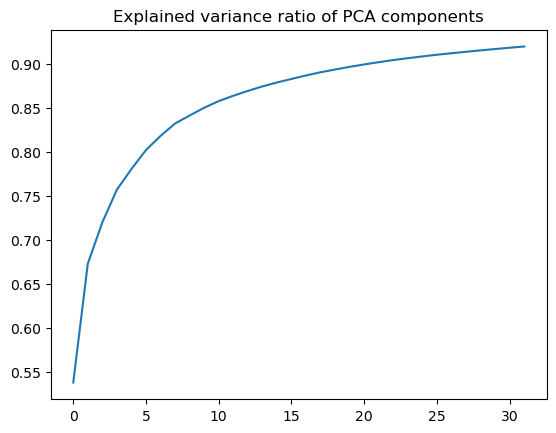

In [16]:
# Investigate the PCA transformer
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance ratio of PCA components")

In [ ]:
# Store the PCA transformer
with open('../transformers/trained_pca_transformer.pickle', 'wb') as handle:
    pickle.dump(pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

## hSFA

In [ ]:
%%time
# Train hsfa_transformer if none can be imported:
# Time scales linearly with number of training samples

layer_configurations = [
    (10, 10, 5, 5, 32, 2),
    (3, 3, 2, 3, 32, 2)
]

hsfa = HSFA(n_components=32,
            input_shape=obs.shape[1:],
            layer_configurations=layer_configurations,
            internal_batch_size=50,
            noise_std=10e-3,
            verbose=1)

hsfa.summary()
hsfa.fit(obs)

In [19]:
# Store the hSFA transformer
with open('../transformers/trained_hsfa_transformer.pickle', 'wb') as handle:
    pickle.dump(hsfa, handle, protocol=pickle.HIGHEST_PROTOCOL)